In [1]:
import pandas as pd
import numpy as np

import re
import string

from nltk.corpus import stopwords
import gensim
from gensim import corpora
import nltk
# libraries for visualization
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
from nltk.tag import pos_tag
from sklearn.manifold import TSNE

/Users/yashjain/miniforge3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/yashjain/miniforge3/envs/tensorflow/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/yashjain/miniforge3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/yashjain/miniforge3/envs/tensorflow/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/yashjain/miniforge3/envs/tensorflow/lib/python3.9

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'all_combined', index_col=None) 

In [3]:
df['goal_short_name'].unique()

array(['plant_proteins', 'fruit', 'choose_whole_grain_carbs', 'water',
       'variety_fruits_vegetables', 'lean_proteins', 'low_fat',
       'low_fat_dairy', 'low_glycemic_index', 'no_added_sugar',
       'vegetable_fats', 'vegetables', 'whole_grains'], dtype=object)

In [4]:
#implementing a spell check
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('data.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [5]:
correction('con')

'corn'

In [6]:
correction('weat')

'wheat'

In [7]:
correction('peeper')

'pepper'

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english') + list(string.punctuation))
stop_words.update(['oz', 'tbsp', 'lb', 'lbs', 'cup', 'tablespoon', 'tsp', 'teaspoon', 'numbers', 'half', 'bowl', 'bottle', 'tspn'])
# Define a set
punctuation = ['!','"','#','$','%','&',"'",'(',')','*', '+',',','-','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','1','2','3','4','5', '6', '7', '8', '9','0']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def preprocess_meals(meal):
    processed_meal = ''
    for i in meal:
        if i not in punctuation: #remove any punctuation marks
            processed_meal += i
    processed_meal = processed_meal.lower() #llower case
    processed_meal = " ".join(correction(word) for word in processed_meal.split())#spell check and correct the words
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words)#remove stop words
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split() if len(word)>2)#lemmatization
    processed_meal = processed_meal.replace('\d+', '')#removing digits if any
    return(processed_meal)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment']
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [11]:
#df = df[df['expert_assessment']==1]

df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str) #combining ingredients and title

df['ingredients_and_title']

0                                         Pretzel Pretzel
1            Turkey burger salad Salad with turkey burger
2             Quinoa and vegetables Quinoa and vegetables
3         Chicken and salad Chicken with mixed vegetables
4       Salad and sweet potatoes Salad ,sweet potatoes...
                              ...                        
7245    Chicken patty,  wholewheat wrap ,mozzarella ch...
7246    Bowl of oatmeal, 2 x hard-boiled eggs and 16 o...
7247                                       Oatmeal Cereal
7248    Whiting fish sandwich with 1 x tablespoon of t...
7249    Bowl of Minestrone soup, 2 x slices of whole w...
Name: ingredients_and_title, Length: 7250, dtype: object

In [12]:
df['ingredients_and_title'] = df['ingredients_and_title'].apply(lambda x: preprocess_meals(x))

In [13]:
df_list = df['ingredients_and_title'].tolist()

In [14]:
df_list = [d.split() for d in df_list]

In [15]:
# Creating term dictionary of corpus, where each unique term is assigned an index.
dictionary = corpora.Dictionary(df_list) #making a dictionary
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df_list] 

In [16]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=8, random_state=100,
                chunksize=50, passes=50,iterations=1000) #building the LDA model

In [17]:
lda_model.print_topics()

[(0,
  '0.117*"potato" + 0.071*"turkey" + 0.049*"carrot" + 0.036*"punch" + 0.031*"shrimp" + 0.031*"veggie" + 0.031*"mustard" + 0.030*"baker" + 0.028*"string" + 0.028*"juice"'),
 (1,
  '0.100*"salad" + 0.085*"water" + 0.081*"white" + 0.077*"rice" + 0.071*"bean" + 0.064*"chicken" + 0.050*"tomato" + 0.035*"lettuce" + 0.035*"mixed" + 0.026*"carrot"'),
 (2,
  '0.116*"chicken" + 0.067*"rice" + 0.058*"corn" + 0.048*"pork" + 0.048*"broccoli" + 0.044*"vegetable" + 0.043*"fried" + 0.042*"sauce" + 0.034*"white" + 0.029*"roast"'),
 (3,
  '0.109*"onion" + 0.053*"pepper" + 0.048*"green" + 0.042*"breast" + 0.037*"yogurt" + 0.037*"fish" + 0.032*"tomato" + 0.032*"water" + 0.028*"olive" + 0.028*"oil"'),
 (4,
  '0.116*"egg" + 0.089*"cut" + 0.071*"coffee" + 0.060*"white" + 0.052*"black" + 0.049*"cheese" + 0.049*"banana" + 0.036*"sugar" + 0.031*"bread" + 0.030*"hardboiled"'),
 (5,
  '0.107*"cheese" + 0.057*"butter" + 0.049*"hot" + 0.039*"cream" + 0.030*"large" + 0.028*"white" + 0.024*"boiled" + 0.022*"chip

In [18]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.166364 -0.264150       1        1  20.785013
1     -0.034296  0.095453       2        1  19.428464
3      0.189765  0.041740       3        1  11.954768
2     -0.187397  0.234114       4        1  11.910054
6      0.242364 -0.129142       5        1  11.785335
0     -0.045061  0.234765       6        1   8.731785
5     -0.221998 -0.190130       7        1   8.167811
7      0.222987 -0.022649       8        1   7.236771, topic_info=          Term         Freq        Total Category  logprob  loglift
14         egg  1782.000000  1782.000000  Default  30.0000  30.0000
66       water  3084.000000  3084.000000  Default  29.0000  29.0000
7      chicken  1944.000000  1944.000000  Default  28.0000  28.0000
2        salad  1437.000000  1437.000000  Default  27.0000  27.0000
52         cut  1370.000000  1370.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1119    lipton    28.957737    29.772236   Topic8  -5.2158   2.5983
551     nonfat    27.072571    27.886992   Topic8  -5.2831   2.5964
246       form    26.328415    27.143127   Topic8  -5.3110   2.5955
243   cinnamon    80.328637   122.654312   Topic8  -4.1955   2.2028
66       water   366.602953  3084.051534   Topic8  -2.6773   0.4963

[311 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200       5  0.995093     almond
119       1  0.990914      apple
147       2  0.993606  asparagus
9         3  0.342484    avocado
9         4  0.652351    avocado
...     ...       ...        ...
117       2  0.998086     yellow
128       3  0.996633     yogurt
298       5  0.988201       zest
948       2  0.984007       ziti
543       5  0.987076   zucchini

[291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 7, 1, 6, 8])

In [19]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=df_list, start=2, limit=15, step=1)

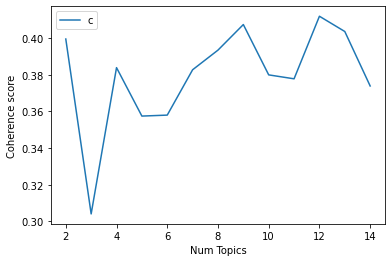

In [21]:
# Show graph
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [44]:
bow = dictionary.doc2bow(df_list[10])
top_topics = lda_model.get_document_topics(bow, minimum_probability=0.0) #Topic probabilities for the 10th item in the dataset

In [45]:
top_topics 

[(0, 0.12568821),
 (1, 0.19649455),
 (2, 0.47936988),
 (3, 0.0136979595),
 (4, 0.14366208),
 (5, 0.013697287),
 (6, 0.013694584),
 (7, 0.01369542)]

## For all

In [24]:
train_vec = [] #making features out of the probability of a meal being in a cluster
for d in df_list:
    bow = dictionary.doc2bow(d)
    top_topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(8)] #8 is number of topics
    train_vec.append(topic_vec)

In [25]:
train = pd.DataFrame(train_vec, columns = ['Topic 0', 'Topic 1','Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7'])

In [26]:
train

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,0.708295,0.041672,0.041672,0.041672,0.041672,0.041672,0.041672,0.041672
1,0.515624,0.390608,0.015630,0.015625,0.015633,0.015629,0.015625,0.015626
2,0.025001,0.025001,0.425013,0.025001,0.025001,0.025001,0.424982,0.025001
3,0.017857,0.570106,0.322742,0.017857,0.017863,0.017860,0.017857,0.017858
4,0.265631,0.265630,0.140595,0.015648,0.265619,0.015625,0.015625,0.015625
...,...,...,...,...,...,...,...,...
7245,0.010417,0.315970,0.010440,0.010417,0.107044,0.524877,0.010417,0.010418
7246,0.011364,0.011373,0.011364,0.011367,0.639253,0.011364,0.292544,0.011371
7247,0.041667,0.041667,0.041667,0.041667,0.374997,0.041667,0.041667,0.375000
7248,0.008932,0.008952,0.120709,0.158964,0.008942,0.112730,0.571838,0.008932


In [27]:
data_X = train
data_y = df['expert_assessment']

In [28]:
data_y.value_counts()

0.0    4261
1.0    2989
Name: expert_assessment, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(data_X, data_y, test_size = 0.3)

In [30]:
#Checking if probability of being in a particular cluster fullfils goals or not 
from sklearn import svm
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='rbf')
clf.fit(X_dev, y_dev)
y_pred_dev = clf.predict(X_dev)
y_pred_test = clf.predict(X_test)
print('Development accuracy:', accuracy_score(y_dev, y_pred_dev))
print('Test accuracy:', accuracy_score(y_test, y_pred_test))

Development accuracy: 0.6228571428571429
Test accuracy: 0.5963218390804598


In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_dev, y_dev)
y_pred_dev = lr.predict(X_dev)
y_pred_test = lr.predict(X_test)
print('Development accuracy:', accuracy_score(y_dev, y_pred_dev))
print('Test accuracy:', accuracy_score(y_test, y_pred_test))

Development accuracy: 0.594088669950739
Test accuracy: 0.5696551724137932


## For a goal

In [32]:
df_plant_proteins = df[df['goal_short_name'] == 'plant_proteins']

In [33]:
df_plant_proteins_list = df_plant_proteins['ingredients_and_title'].tolist()

In [34]:
df_plant_proteins_list = [d.split() for d in df_plant_proteins_list]

In [35]:
train_vec = []
for d in df_plant_proteins_list:
    bow = dictionary.doc2bow(d)
    top_topics = lda_model.get_document_topics(bow, minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(8)] #6 is number of topics
    train_vec.append(topic_vec)

In [36]:
train = pd.DataFrame(train_vec, columns = ['Topic 0', 'Topic 1','Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7'])

In [37]:
train

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
0,0.708295,0.041672,0.041672,0.041672,0.041672,0.041672,0.041672,0.041672
1,0.515624,0.390608,0.015630,0.015625,0.015633,0.015629,0.015625,0.015626
2,0.025001,0.025001,0.425013,0.025001,0.025001,0.025001,0.424982,0.025001
3,0.017857,0.569881,0.322967,0.017857,0.017863,0.017860,0.017857,0.017858
4,0.265631,0.265630,0.140590,0.015653,0.265619,0.015625,0.015625,0.015625
...,...,...,...,...,...,...,...,...
482,0.005208,0.963531,0.005211,0.005210,0.005210,0.005211,0.005210,0.005209
483,0.008929,0.708766,0.008932,0.008930,0.169396,0.008929,0.077188,0.008931
484,0.075889,0.040904,0.004475,0.049518,0.780107,0.040176,0.004466,0.004464
485,0.017857,0.017857,0.017857,0.017857,0.875000,0.017857,0.017857,0.017857


In [38]:
data_X = train
data_y = df_plant_proteins['expert_assessment']

In [39]:
data_y.value_counts()

0.0    404
1.0     83
Name: expert_assessment, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(data_X, data_y, test_size = 0.33)

In [41]:
#Checking if probability of being in a particular cluster fullfils goals or not per goalwise
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_dev, y_dev)
y_pred_dev = clf.predict(X_dev)
y_pred_test = clf.predict(X_test)
print('Development accuracy:', accuracy_score(y_dev, y_pred_dev))
print('Test accuracy:', accuracy_score(y_test, y_pred_test))

Development accuracy: 0.8251533742331288
Test accuracy: 0.8385093167701864


In [42]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_dev, y_dev)
y_pred_dev = lr.predict(X_dev)
y_pred_test = lr.predict(X_test)
print('Development accuracy:', accuracy_score(y_dev, y_pred_dev))
print('Test accuracy:', accuracy_score(y_test, y_pred_test))

Development accuracy: 0.8251533742331288
Test accuracy: 0.8385093167701864


In [43]:
lr.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])